In [3]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import numpy as np
from tensorboardX import SummaryWriter
import matplotlib.pyplot as plt

#add holes to the thresholding units. 
#Seek to only use signals, in [a, b], [b+1.0, c], [c+1.0, ...]

In [171]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyper-parameters 
input_size = 784
hidden_size = 500
num_classes = 10
batch_size = 100
num_workers=0
learning_rate = 0.001

num_epochs = 5

In [16]:
transform = transforms.ToTensor()
train_data = datasets.MNIST(root='/Users/dongcui/github/visualising-cnns/data', train=True,
                                   download=False, transform=transform)
test_data = datasets.MNIST(root='/Users/dongcui/github/visualising-cnns/data', train=False,
                                  download=False, transform=transform)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    num_workers=num_workers, shuffle = True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    num_workers=num_workers, shuffle = True)

In [387]:
def thru(A, low, high):
    C = torch.gt(A, low) & torch.lt(A, high)
    CA = C.float() * A 
#     CA = C.float()  
#     CN = (CA - low) / (high - low)
#     return CN
    return CA

A = torch.randn(3,3)
print(A)
print(thru(A, 0, 1.0))

# A = torch.randn(2,3,3)
# print(A)

# print(thru(A, 0, 0.5))


tensor([[ 0.0949, -0.0885, -1.9608],
        [-1.2076, -1.6392,  0.0681],
        [ 0.1333,  1.6226, -1.2295]])
tensor([[0.0949, -0.0000, -0.0000],
        [-0.0000, -0.0000, 0.0681],
        [0.1333, 0.0000, -0.0000]])


In [365]:
class Thru(nn.Module):
    '''
    Applies the Sigmoid Linear Unit (SiLU) function element-wise:
        SiLU(x) = x * sigmoid(x)
    Shape:
        - Input: (N, *) where * means, any number of additional
          dimensions
        - Output: (N, *), same shape as the input
    References:
        -  Related paper:
        https://arxiv.org/pdf/1606.08415.pdf
    Examples:
        >>> m = silu()
        >>> input = torch.randn(2)
        >>> output = m(input)
    '''
    def __init__(self, low, high):
        '''
        Init method.
        '''
        super().__init__() # init the base class
        self.low=low
        self.high=high

    def forward(self, input):
        '''
        Forward pass of the function.
        '''
        return thru(input, self.low, self.high)




In [384]:
class ThresholdingHoles(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(ThresholdingHoles, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size) 
        
#         self.thru1 = Thru(0.0, 10.0)
#         self.thru2 = Thru(0.0, 100.0)
        self.thru1 = Thru(0.0, 10.0)

        self.fc2 = nn.Linear(hidden_size, hidden_size)  
        self.thru2 = Thru(0.0, 10.0)
            
        self.fc3 = nn.Linear(hidden_size, 100)  
        self.thru3 = Thru(0.0, 10.0)
        
        self.fc4 = nn.Linear(100, num_classes)  
    
    def forward(self, x):
        out = x

        out_lin = self.fc1(out)
        out = self.thru1(out_lin)
        out = self.fc2(out)
        out = self.thru2(out)
        out = self.fc3(out)
        out = self.thru3(out)
        out = self.fc4(out)
        
        return out #, out1, out2 
    
model = ThresholdingHoles(input_size, hidden_size, num_classes).to(device)
    
#visualzing graphs
# writer=SummaryWriter('runs/thresholding')
# dataiter=iter(train_loader)
# images, labels = dataiter.next()
# grid = torchvision.utils.make_grid(images)
# #writer.add_image('images', grid, 0)

# # images = images.reshape(-1, 28*28).to(device)
# dummy_input = torch.zeros(1, 28*28),
# writer.add_graph(model, dummy_input)
# writer.close()




Epoch [1/5], Step [100/600], Loss: 0.3355
Epoch [1/5], Step [200/600], Loss: 0.2760
Epoch [1/5], Step [300/600], Loss: 0.2182
Epoch [1/5], Step [400/600], Loss: 0.0832
Epoch [1/5], Step [500/600], Loss: 0.1417
Epoch [1/5], Step [600/600], Loss: 0.0573
Epoch [2/5], Step [100/600], Loss: 0.1644
Epoch [2/5], Step [200/600], Loss: 0.0811
Epoch [2/5], Step [300/600], Loss: 0.0519
Epoch [2/5], Step [400/600], Loss: 0.0425
Epoch [2/5], Step [500/600], Loss: 0.0730
Epoch [2/5], Step [600/600], Loss: 0.0596
Epoch [3/5], Step [100/600], Loss: 0.0273
Epoch [3/5], Step [200/600], Loss: 0.0604
Epoch [3/5], Step [300/600], Loss: 0.0304
Epoch [3/5], Step [400/600], Loss: 0.0261
Epoch [3/5], Step [500/600], Loss: 0.0198
Epoch [3/5], Step [600/600], Loss: 0.0653
Epoch [4/5], Step [100/600], Loss: 0.0258
Epoch [4/5], Step [200/600], Loss: 0.0134
Epoch [4/5], Step [300/600], Loss: 0.1109
Epoch [4/5], Step [400/600], Loss: 0.0244
Epoch [4/5], Step [500/600], Loss: 0.0209
Epoch [4/5], Step [600/600], Loss:

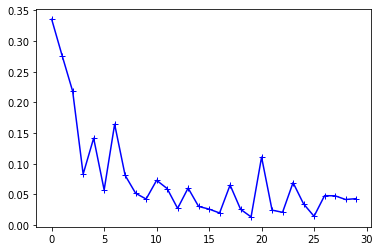

0.07694190374265114


In [385]:
import time

start = time.time()

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  

# Train the model
total_step = len(train_loader)
losses=[]
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):  
        # Move tensors to the configured device
        images = images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
            losses.append(loss.item())
            

print('elapsed: ', time.time()-start)
plt.plot(losses, '-b+')
plt.show()
print(np.mean(losses))


In [386]:
# Test the model
# In test phase, we don't need to compute gradients (for memory efficiency)
labels_wrong = []
pred_wrong = []
img_wrong = []
with torch.no_grad():
    correct = 0
    total = 0
    for img, labels in test_loader:
#         print(img.shape)
        images = img.reshape(-1, 28*28).to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        wrong_preds = (predicted != labels).numpy()
        wrong_index = []
        for (i, wrong) in enumerate(wrong_preds):
            if wrong:
                wrong_index.append(i) 
        if len(wrong_index) > 0:
            img_reshaped = img[wrong_index].numpy()[:,0,:,:]
            for img_w in range(img_reshaped.shape[0]):
                img_wrong.append(img_reshaped[img_w])
            labels_wrong  += (labels[wrong_index].numpy().tolist())
            pred_wrong += (predicted[wrong_index].numpy().tolist())
#     print(img_wrong)
#     print('img_wrong.shape', img_wrong[0].shape)
#     print('lables_wrong =', labels_wrong)
#     print('predictions wrong are:', pred_wrong)
    print('Accuracy of the network on the 10000 test images: {} %'.format(100 * correct / total))

#show wrong images:
# print(len(img_wrong), ', ', len(labels_wrong), ', ', len(pred_wrong))
# for i in range(len(img_wrong)):
#     plt.imshow(img_wrong[i])
#     print('labels_wrong[i]:', labels_wrong[i])
#     print('pred_wrong[i]', pred_wrong[i])
#     plt.pause(1)

# Save the model checkpoint
# torch.save(model.state_dict(), 'model.ckpt')

Accuracy of the network on the 10000 test images: 97.9 %


In [ ]:
print('layer 1:')
w_fc1 = list(model.fc1.parameters())
print(w_fc1)

print('layer 2:')
w_fc2 = list(model.fc2.parameters())
print(w_fc2)

#check dead neurons
images, labels = dataiter.next()
images = images.reshape(-1, 28*28).to(device)
# print(images.shape)
A1 = images[:1]
# print(A1.shape)
output, output_relu, output_minlu = model(A1)

output_relu = output_relu.T.detach()
# print(output_relu.shape)
# plt.plot(output_relu.numpy(), '-b+')
# plt.show()
print('np.count_nonzero(output_relu)=', np.count_nonzero(output_relu))
# print('sparsity', 1- np.count_nonzero(output_relu)/ (output_relu.shape[0] * output_relu.shape[1]))

output_minlu = output_minlu.T.detach()
print(output_minlu.shape)
plt.plot(output_minlu.numpy(), '-b+')
print('np.count_nonzero(output_minlu)=', np.count_nonzero(output_minlu))
# plt.show()

#either one of minlu and relu must be activated. ignore zero features. 
assert (np.count_nonzero(output_minlu) + np.count_nonzero(output_relu) == hidden_size)

In [ ]:
#future work
def relu_at(A, threshold):
    return torch.max(A, torch.ones_like(A) * threshold)

def relu_min_at(A, threshold):
    return torch.min(A, torch.ones_like(A) * threshold)

class ThresholdingNet2(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(ThresholdingNet2, self).__init__()
        self.maxlu = ReLU_my()
        self.minlu = ReLU_min()
        self.fc1 = nn.Linear(input_size*2, hidden_size) 
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)  
    
    def forward(self, x):
        out = x
        
        out1 = self.maxlu(out)
        out2 = self.minlu(out)
        out = torch.cat((out1, out2), dim=1)
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        return out  
    
# model = ThresholdingNet(input_size, hidden_size, num_classes).to(device)
model = ThresholdingNet2(input_size, hidden_size, num_classes).to(device)